In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [25]:
path = "./dataset/riceClassification.csv"

df = pd.read_csv(path)

In [26]:
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [27]:
df.dropna(inplace=True)
df.drop(["id"], axis=1, inplace=True)

In [28]:
print(df.shape)
print(df["Class"].value_counts())

(18185, 11)
Class
1    9985
0    8200
Name: count, dtype: int64


In [29]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [30]:
original_df = df.copy()

for column in df.columns:
    df[column] = df[column] / df[column].abs().max()

In [31]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [32]:
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [34]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [35]:
training_dataset = dataset(X_train, y_train)
testing_dataset = dataset(X_test, y_test)
validating_dataset = dataset(X_val, y_val)

In [36]:
batch_size = 32

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)
validating_dataloader = DataLoader(
    validating_dataset, batch_size=batch_size, shuffle=True
)

In [37]:
HIDDEN_LAYERS = 10


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_LAYERS)
        self.linear = nn.Linear(HIDDEN_LAYERS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)

        return x


model = MyModel().to(device)

In [38]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [39]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [40]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_validation = 0
    total_loss_validation = 0

    for data in training_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validating_dataloader:
            inputs, labels = data
            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_validation += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()
            total_acc_validation += acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_validation / 1000, 4))

    total_acc_train_plot.append(
        round(total_acc_train / training_dataset.__len__() * 100, 4)
    )
    total_acc_validation_plot.append(
        round(total_acc_validation / validating_dataset.__len__() * 100, 4)
    )

    print(f""" Epoch No {epoch + 1}
                Train Loss: {round(total_loss_train / 1000, 4)}
                Train Acc: {round(total_acc_train / training_dataset.__len__() * 100, 4)}
                Validation Loss: {round(total_loss_validation / 1000, 4)}
                Val Acc: {round(total_acc_validation / validating_dataset.__len__() * 100, 4)}
            """)

 Epoch No 1
                Train Loss: 0.2377
                Train Acc: 81.3182
                Validation Loss: 0.0382
                Val Acc: 96.2977
            
 Epoch No 2
                Train Loss: 0.1196
                Train Acc: 97.9888
                Validation Loss: 0.0157
                Val Acc: 98.3138
            
 Epoch No 3
                Train Loss: 0.056
                Train Acc: 98.2952
                Validation Loss: 0.0083
                Val Acc: 98.717
            
 Epoch No 4
                Train Loss: 0.036
                Train Acc: 98.4681
                Validation Loss: 0.0058
                Val Acc: 98.937
            
 Epoch No 5
                Train Loss: 0.0281
                Train Acc: 98.4838
                Validation Loss: 0.0044
                Val Acc: 98.7537
            
 Epoch No 6
                Train Loss: 0.0239
                Train Acc: 98.5152
                Validation Loss: 0.0038
                Val Acc: 98.8636
         

In [41]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in testing_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()

        total_loss_test += batch_loss_test

        acc = ((prediction).round() == labels).sum().item()
        total_acc_test += acc

    print(f"""Test Acc: {round(total_acc_test / testing_dataset.__len__() * 100, 4)}
                 """)

Test Acc: 98.5337
                 


In [42]:
# Convert to TorchScript
scripted_model = torch.jit.script(model)
scripted_model.save("model_scripted.pt")

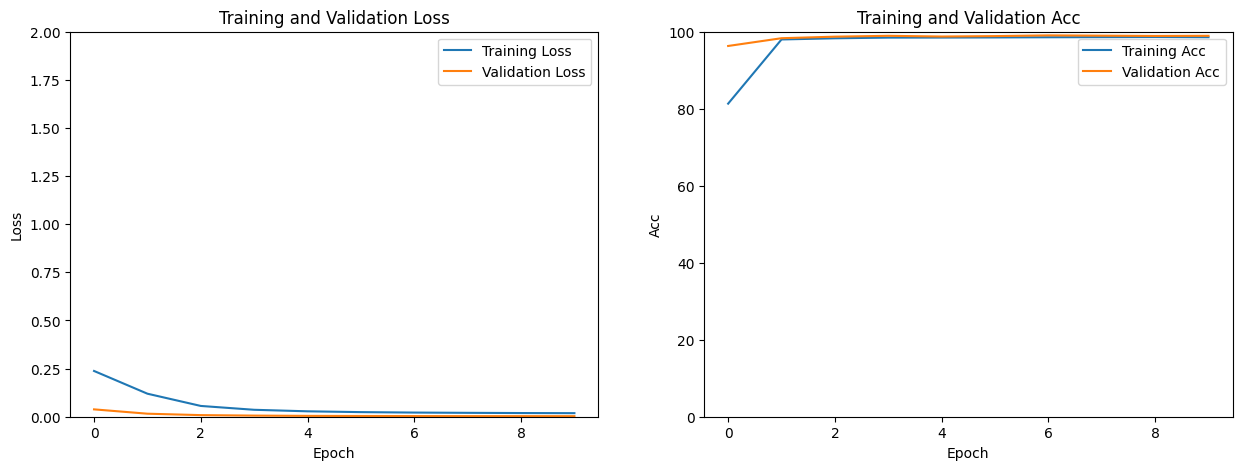

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Training Loss")
axs[0].plot(total_loss_validation_plot, label="Validation Loss")
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0, 2])
axs[0].legend()


axs[1].plot(total_acc_train_plot, label="Training Acc")
axs[1].plot(total_acc_validation_plot, label="Validation Acc")
axs[1].set_title("Training and Validation Acc")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Acc")
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.show()